In [4]:
import warnings
import pandas as pd
from pymodulon.compare import compare_ica
from pymodulon.io import load_json_model, save_to_json

import logging
import os
import subprocess
from glob import glob

import numpy as np
import pandas as pd
from Bio import SeqIO
from graphviz import Digraph
from pymodulon.compare import _get_orthologous_imodulons, convert_gene_index


warnings.simplefilter(action='ignore', category=FutureWarning)
ucsd_ica = '../Data/ucsd_ica/ica_final_mi.json'
ucsd_ica = load_json_model(ucsd_ica)
ucsd_ica.imodulon_names = ucsd_ica.imodulon_table['name']


ica_data = '../Data/ica/ica_data.json'
ica_data = load_json_model(ica_data)
ica_data.imodulon_names = ica_data.imodulon_table['name']


In [ ]:
import logging
from graphviz import Digraph
from pymodulon.compare import _get_orthologous_imodulons, convert_gene_index


def _make_dot_graph(links, show_all, names1, names2):
    """
    Given a set of links between M matrices, generates a dot graph of the various
    connected iModulons

    Parameters
    ----------
    links : list
        Names and distances of connected iModulons
    show_all : bool
        Show all iModulons regardless of their linkage (default: False)
    names1 : list
        List of names in dataset 1
    names2 : list
        List of names in dataset 2

    Returns
    -------
    dot: Digraph
        Dot graph of connected iModulons
    """

    link_names1 = [link[0] for link in links]
    link_names2 = [link[1] for link in links]

    if show_all:
        names1 = [str(i) for i in names1]
        names2 = [str(i) for i in names2]
    else:
        # Get names of nodes
        names1 = [str(i) for i in link_names1]
        names2 = [str(i) for i in link_names2]

    # Split names in half if necessary for dataset1
    name_dict1 = {}
    for name in names1:
        val = str(name)
        if len(val) > 10:
            name_dict1[name] = val[: len(val) // 2] + "-\n" + val[len(val) // 2 :]
        else:
            name_dict1[name] = val

    # Split names in half if necessary for dataset2
    name_dict2 = {}
    for name in names2:
        val = str(name)
        if len(val) > 10:
            name_dict2[name] = val[: len(val) // 2] + "-\n" + val[len(val) // 2 :]
        else:
            name_dict2[name] = val

    # Initialize Graph
    dot = Digraph(
        engine="dot",
        graph_attr={
            "ranksep": "0.3",
            "nodesep": "0",
            "packmode": "array_u",
            "size": "10,10",
        },
        node_attr={"fontsize": "14", "shape": "none"},
        edge_attr={"arrowsize": "0.5"},
        format="png",
    )

    if len(links) == 0:
        logging.warning("No components shared across runs")
        return dot

    # Initialize Nodes
    for k in sorted(names2):
        if k in link_names2:
            color = "black"
            font = "helvetica"
        else:
            color = "gray"
            font = "helvetica-bold"
        dot.node(
            "data2_" + str(k),
            label=name_dict2[k],
            _attributes={"fontcolor": color, "fontname": font},
        )

    for k in sorted(names1):
        if k in link_names1:
            color = "blue"
            font = "helvetica"
        else:
            color = "red"
            font = "helvetica-bold"
        dot.node(
            "data1_" + str(k),
            label=name_dict1[k],
            _attributes={"fontcolor": color, "fontname": font},
        )

    # Add links between related components
    for k1, k2, dist in links:
        width = dist * 5
        dot.edge(
            "data1_" + str(k1),
            "data2_" + str(k2),
            _attributes={"penwidth": "{:.2f}".format(width)},
        )

    return dot


def compare_ica(
    M1, M2, ortho_file=None, cutoff=0.25, method="pearson", plot=True, show_all=False
):
    """
    Compares two M matrices between a single organism or across organisms and
    returns the connected iModulons

    Parameters
    ----------
    M1 : ~pandas.DataFrame
        M matrix from the first organism
    M2 : ~pandas.DataFrame
        M matrix from the second organism
    ortho_file : str, optional
        Path to orthology file between organisms (default: None)
    cutoff : float
        Cut off value for correlation metric (default: .25)
    method : str or ~typing.Callable
        Correlation metric to use from {‘pearson’, ‘kendall’, ‘spearman’}
        or callable (see :meth:`~pandas.DataFrame.corr`)
    plot : bool
        Create dot plot of matches (default: True)
    show_all : bool
        Show all iModulons regardless of their linkage (default: False)

    Returns
    -------
    matches: list
        Links and distances of connected iModulons
    dot: Digraph
        Dot graph of connected iModulons
    """

    new_M1, new_M2 = convert_gene_index(M1, M2, ortho_file)
    matches = _get_orthologous_imodulons(new_M1, new_M2, method=method, cutoff=cutoff)
    if plot:
        dot = _make_dot_graph(
            matches, show_all=show_all, names1=M1.columns, names2=M2.columns
        )
        return matches, dot
    else:
        return matches
 
    

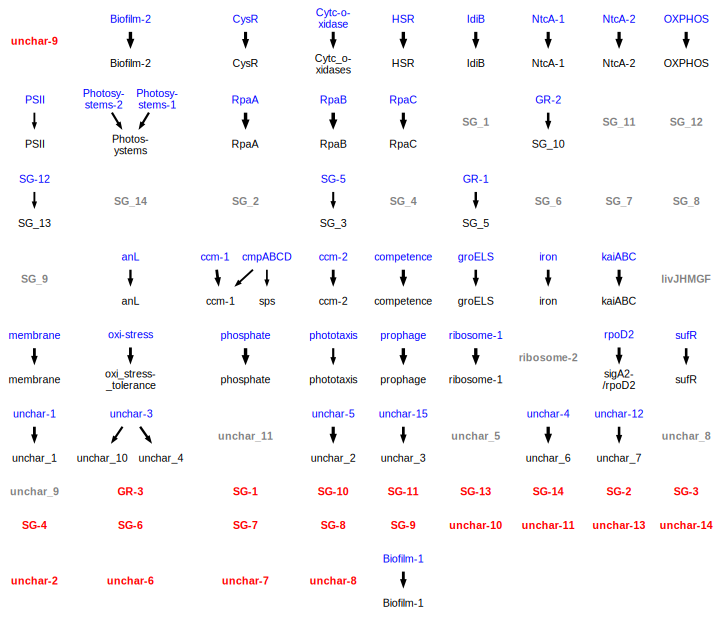

In [ ]:
   
mapping = ica_data.gene_table.reset_index().rename(
    columns={
        'index':'gene', 
        'old_locus_tag':'subject',
        'ncbi_protein':'protein_name',
        'gene_name':'name'
        }
    )[['gene','subject','name']].dropna(
        subset=['subject']
    )

links, dots = compare_ica(ica_data.M,ucsd_ica.M,cutoff=0.3,
                         ortho_file = mapping, show_all=True)

dots